# IBJJF European Championship - Scraping + Analysis

Trying out Beautiful Soup to scrape the <a href='https://www.bjjcompsystem.com/?tournament_id=1985'>results site</a> of the IBJJF European Championship (Paris 2023) as a little pet project.



**<a name='0'>Table of contents</a>**

1. <a href='#1'>Importing libraries</a>
2. <a href='#2'>Scrape the "divisions" page</a>
    * <a href='#21'>2.1. Gender id = 1 (male)</a>
    * <a href='#22'>2.2. Gender id = 2 (female)</a>
    * <a href='#23'>2.3. Concatenate the dataframes</a>
3. <a href='#3'>Scrape the "results" pages</a>
    * <a href='#31'>3.1. Define and validate helper functions</a>
    * <a href='#32'>3.2. Create fight to bracket mapping table</a>
    * <a href='#33'>3.3. Loop through divisions, brackets and fights to populate denormalised dataframe</a>


## 1. <a name='1'>Importing libraries</a>
(<a href='#0'>Go to top</a>)

In [125]:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

## 2. <a name='2'>Scrape the "divisions" page</a>
(<a href='#0'>Go to top</a>)

This page lists all the possible divisions based on age category, belt colour as well as weight class, laid out in an array of boxes. Each box links to a unique page that displays the results of the division (c.f. <a href='#3'>the next section</a> for the results).There are 2 versions of this page, one for gender id 1 ("male") and one for gender id 2 ("female"), let's scrape one after the other.

### 2.1. <a name='21'>Gender id 1 page (male)</a>
(<a href='#0'>Go to top</a>)

This is what the page looks like:

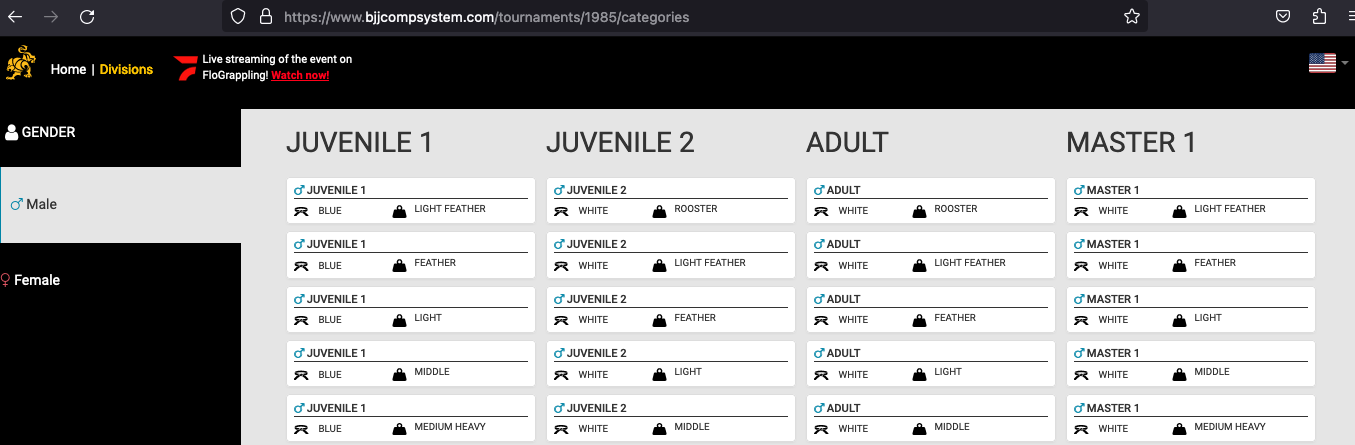

In [126]:
url = 'https://www.bjjcompsystem.com/tournaments/1985/categories?gender_id=1'
r = requests.get(url)
soup = BeautifulSoup(r.content, 'html.parser')
cat_list = soup.findAll('li', attrs = {'class': 'categories-grid__category'})

print('There are {} male division boxes on the {} URL.'.format(len(cat_list), url))

There are 308 male division boxes on the https://www.bjjcompsystem.com/tournaments/1985/categories?gender_id=1 URL.


Here is what the HTML looks like (we're basically getting one box at a time):

In [127]:
print(cat_list[0])

<li class="categories-grid__category">
<a href="/tournaments/1985/categories/2138988"><div class="category-card category-card--male panel panel-default">
<div class="category-card__age-division">
<i class="fa fa-mars"></i>
Juvenile 1 
</div>
<hr class="category-card__separator"/>
<div class="category-card__labels">
<span class="category-card__label category-card__belt-label">
<span class="category-card__label-text">
<i class="fa fa-belt"></i>
 BLUE 
</span>
</span>
<span class="category-card__label category-card__weight-label">
<span class="category-card__label-text">
<i class="fa fa-weight"></i>
 Light Feather
</span>
</span>
</div>
</div>
</a></li>


Another box as an example:

In [128]:
print(cat_list[1])

<li class="categories-grid__category">
<a href="/tournaments/1985/categories/2138991"><div class="category-card category-card--male panel panel-default">
<div class="category-card__age-division">
<i class="fa fa-mars"></i>
Juvenile 1 
</div>
<hr class="category-card__separator"/>
<div class="category-card__labels">
<span class="category-card__label category-card__belt-label">
<span class="category-card__label-text">
<i class="fa fa-belt"></i>
 BLUE 
</span>
</span>
<span class="category-card__label category-card__weight-label">
<span class="category-card__label-text">
<i class="fa fa-weight"></i>
 Feather
</span>
</span>
</div>
</div>
</a></li>


Let's scrape the page and store the info in a dataframe:

In [129]:
prefix = 'https://www.bjjcompsystem.com/tournaments/1985/categories/'

# initialise with empty lists
url_list = []
age_list = []
belt_list = []
weight_list = []

# populate empty lists with division URL, age group and belt colour
for i in range(len(cat_list)):
    s = str(cat_list[i])
    url_list.append(prefix + re.search('(tournaments/1985/categories/)(\d+)', s).group(2))
    age_list.append(re.search('(<i class="fa fa-mars"></i>\\n)(.+)(\\n</div>)', s).group(2))
    belt_list.append(re.search('(<i class="fa fa-belt"></i>\\n)(.+)(\\n</span>)', s).group(2))
    weight_list.append(re.search('(<i class="fa fa-weight"></i>\\n)(.+)(\\n</span>)', s).group(2))
    
# store in dataframe    
df_div1 = pd.DataFrame(data = {'url': url_list
                              , 'age': age_list
                              , 'belt': belt_list
                              , 'weight': weight_list})

df_div1['gender'] = 'male'

for c in df_div1.columns:
    df_div1[c] = df_div1[c].apply(str.strip)
    df_div1[c] = df_div1[c].apply(str.lower)

### 2.2. <a name='22'>Gender id 2 page (female)</a>
(<a href='#0'>Go to top</a>)

Let's do it again with the "female" gender version of the page:

In [130]:
url = 'https://www.bjjcompsystem.com/tournaments/1985/categories?gender_id=2'
r = requests.get(url)
soup = BeautifulSoup(r.content, 'html.parser')
cat_list = soup.findAll('li', attrs = {'class': 'categories-grid__category'})

print('There are {} female divisions on the {} URL.'.format(len(cat_list), url))

prefix = 'https://www.bjjcompsystem.com/tournaments/1985/categories/'

# initialise with empty lists
url_list = []
age_list = []
belt_list = []
weight_list = []

# populate empty lists with division URL, age group and belt colour
for i in range(len(cat_list)):
    s = str(cat_list[i])
    url_list.append(prefix + re.search('(tournaments/1985/categories/)(\d+)', s).group(2))
    age_list.append(re.search('(<i class="fa fa-venus"></i>\\n)(.+)(\\n</div>)', s).group(2))
    belt_list.append(re.search('(<i class="fa fa-belt"></i>\\n)(.+)(\\n</span>)', s).group(2))
    weight_list.append(re.search('(<i class="fa fa-weight"></i>\\n)(.+)(\\n</span>)', s).group(2))
    
# store in dataframe    
df_div2 = pd.DataFrame(data = {'url': url_list
                              , 'age': age_list
                              , 'belt': belt_list
                              , 'weight': weight_list})

df_div2['gender'] = 'female'

for c in df_div2.columns:
    df_div2[c] = df_div2[c].apply(str.strip)
    df_div2[c] = df_div2[c].apply(str.lower)

There are 169 female divisions on the https://www.bjjcompsystem.com/tournaments/1985/categories?gender_id=2 URL.


### 2.3. <a name='23'>Concatenate dataframes</a>
(<a href='#0'>Go to top</a>)

Let's stack our dataframes together and output a random sample:

In [131]:
df_div = pd.concat([df_div1, df_div2], ignore_index = True)

print('There are {} divisions in total and as many URLs to scrape!\nHere is a sample of our division data:'.format(len(df_div)))

with pd.option_context('display.max_colwidth', None):
    display(df_div.sample(10))

There are 477 divisions in total and as many URLs to scrape!
Here is a sample of our division data:


,url,age,belt,weight,gender
468,https://www.bjjcompsystem.com/tournaments/1985/categories/2139490,master 4,black,light,female
218,https://www.bjjcompsystem.com/tournaments/1985/categories/2139453,master 4,purple,medium heavy,male
284,https://www.bjjcompsystem.com/tournaments/1985/categories/2139618,master 6,brown,medium heavy,male
336,https://www.bjjcompsystem.com/tournaments/1985/categories/2139162,adult,blue,heavy,female
178,https://www.bjjcompsystem.com/tournaments/1985/categories/2139363,master 3,purple,middle,male
365,https://www.bjjcompsystem.com/tournaments/1985/categories/2139221,master 1,white,light feather,female
457,https://www.bjjcompsystem.com/tournaments/1985/categories/2139487,master 4,blue,light,female
169,https://www.bjjcompsystem.com/tournaments/1985/categories/2139362,master 3,blue,middle,male
280,https://www.bjjcompsystem.com/tournaments/1985/categories/2139629,master 6,purple,ultra heavy,male
332,https://www.bjjcompsystem.com/tournaments/1985/categories/2139142,adult,blue,feather,female


## 3. <a name='3'>Scrape the "results" pages</a>
(<a href='#0'>Go to top</a>)

Here is an example of <a href='https://www.bjjcompsystem.com/tournaments/1985/categories/2139091'>one of these pages</a>:

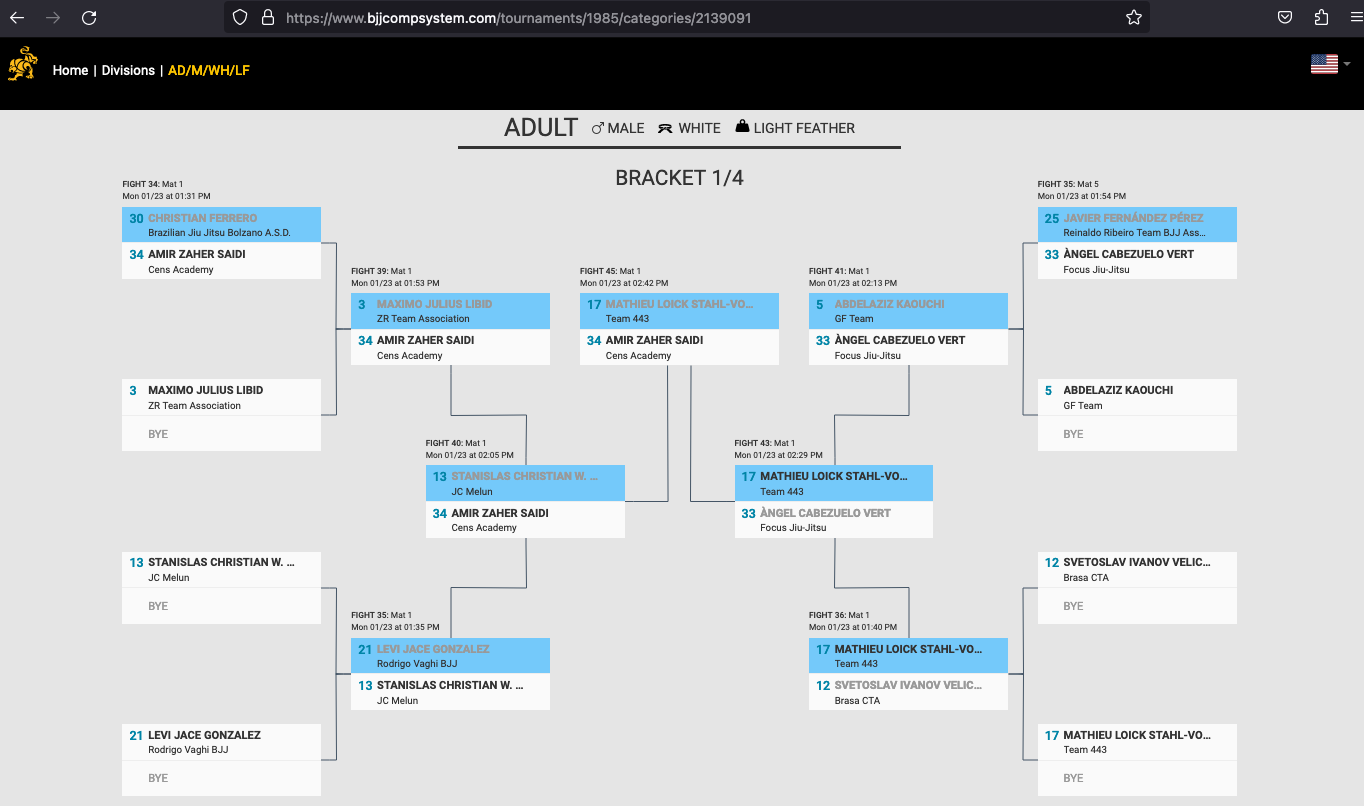

Here is hierarchy we're going to be using: results page > bracket > match > fighter.

### 3.1. <a name='31'>Define and validate helper functions</a>
(<a href='#0'>Go to top</a>)

Functions to get the bracket list, the match details and the podium from the results page using BeautifulSoup:

In [132]:
def get_brackets(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    return soup.findAll('div', attrs = {'class': 'bracket-title'})

def get_matches(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    return soup.findAll('div', attrs = {'class': 'tournament-category__match'})

def get_podium(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    return soup.find('div', attrs = {'class': 'podium'})

def get_podiumranks(podium):
    return podium.findAll('span', attrs = {'class': 'podium__place'})

def get_podiumnames(podium):
    return podium.findAll('div', attrs = {'class': 'podium__competitor-name'})

def get_podiumclubs(podium):
    return podium.findAll('div', attrs = {'class': 'podium__club-name'})

def match_to_bracket_map(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    return soup.findAll('div', attrs = {'class': 'tournament-category__bracket tournament-category__bracket-15'})

Functions to extract readable terms from the HTML using regex:

In [133]:
def extract_bracket_name(bracket_item):
    return (re.search('(<div class="bracket-title">)(.+)(</div>)', str(bracket_item))
            .group(2))

def extract_fightno(match_item):
    try:
        return (re.search('(<span class="bracket-match-header__fight">)(.+)(:</span> )(.+)(</div>\n<div class="bracket-match-header__when">)(.+)(</div>)'
                      , str(match_item)).group(2).lower())
    except AttributeError:
        pass

def extract_matno(match_item):
    try:
        return (re.search('(<span class="bracket-match-header__fight">)(.+)(:</span> )(.+)(</div>\n<div class="bracket-match-header__when">)(.+)(</div>)'
                      , str(match_item)).group(4).lower())
    except AttributeError:
        pass
    
def extract_datetime(match_item):
    try:
        return (re.search('(<span class="bracket-match-header__fight">)(.+)(:</span> )(.+)(</div>\n<div class="bracket-match-header__when">)(.+)(</div>)'
                      , str(match_item)).group(6).lower())
    except AttributeError:
        pass
    
def extract_losername(match_item):
    try:
        return (re.search('(<span class="match-card__competitor-description match-competitor--loser">\n<div class="match-card__competitor-name">)(.+)(</div>\n<div class="match-card__club-name">)(.+)(</div>)'
                      , str(match_item)).group(2))
    except AttributeError:
        pass
    
def extract_loserclub(match_item):
    try:
        return (re.search('(<span class="match-card__competitor-description match-competitor--loser">\n<div class="match-card__competitor-name">)(.+)(</div>\n<div class="match-card__club-name">)(.+)(</div>)'
                      , str(match_item)).group(4))
    except AttributeError:
        pass
    
def extract_winnername(match_item):
    try:
        return (re.search('(<span class="match-card__competitor-description">\n<div class="match-card__competitor-name">)(.+)(</div>\n<div class="match-card__club-name">)(.+)(</div>)'
                      , str(match_item)).group(2))
    except AttributeError:
        pass
    
def extract_winnerclub(match_item):
    try:
        return (re.search('(<span class="match-card__competitor-description">\n<div class="match-card__competitor-name">)(.+)(</div>\n<div class="match-card__club-name">)(.+)(</div>)'
                      , str(match_item)).group(4))
    except AttributeError:
        pass
    
def extract_winnername(match_item):
    try:
        return (re.search('(<span class="match-card__competitor-description">\n<div class="match-card__competitor-name">)(.+)(</div>\n<div class="match-card__club-name">)(.+)(</div>)'
                      , str(match_item)).group(2))
    except AttributeError:
        pass
    
def extract_bye(match_item): # https://en.wikipedia.org/wiki/Bye_(sports)
    try:
        return (re.search('(<div class="match-card__bye">)(.+)(</div>)'
                      , str(match_item)).group(2))
    except AttributeError:
        pass
    
def extract_podiumrank(podium_item):
    try:
        return (re.search('(<span class="podium__place">)(\d+)(</span>)'
                      , str(podium_item)).group(2))
    except AttributeError:
        pass
    
def extract_podiumname(podium_item):
    try:
        return (re.search('(<div class="podium__competitor-name">)(.+)(</div>)'
                      , str(podium_item)).group(2))
    except AttributeError:
        pass
    
def extract_podiumclub(podium_item):
    try:
        return (re.search('(<div class="podium__club-name">)(.+)(</div>)'
                      , str(podium_item)).group(2))
    except AttributeError:
        pass

Here are examples of what the functions above do:

In [134]:
for url in ['https://www.bjjcompsystem.com/tournaments/1985/categories/2139176'
            , 'https://www.bjjcompsystem.com/tournaments/1985/categories/2139091']:

    print('\n ===================== PAGE {} ====================='.format(url))

    bracket_list = get_brackets(url)
    match_list = get_matches(url)
    podium = get_podium(url)

    print('There are {} bracket(s) and {} matche(s) on the page.'.format(len(bracket_list)
                                                                            , len(match_list)))
    
    if len(bracket_list) != 0:
        print('\n    Here are the bracket names:')
        for i in range(len(bracket_list)):
            print('        ', extract_bracket_name(bracket_list[i]))
    
    print('\n    Here is the HTML corresponding to the first match on the page:')
    print(match_list[0])

    print('\n    Here is an example of the info we can extract from the HTML above:')
    print('            - fight number:', extract_fightno(match_list[0]))
    print('            - where:', extract_matno(match_list[0]))
    print('            - when:', extract_datetime(match_list[0]))
    print('            - winner: {} ({})'.format(extract_winnername(match_list[0])
                                                , extract_winnerclub(match_list[0])))
    print('            - loser: {} ({})'.format(extract_losername(match_list[0])
                                                , extract_loserclub(match_list[0])))
    print('            - Bye? {}'.format(extract_bye(match_list[0])))

    print('\n    Here is the HTML corresponding to the last match on the page:')
    print(match_list[-1])

    print('\n    Here is an example of the info we can extract from the HTML above:')
    print('            - fight number:', extract_fightno(match_list[-1]))
    print('            - where:', extract_matno(match_list[-1]))
    print('            - when:', extract_datetime(match_list[-1]))
    print('            - winner: {} ({})'.format(extract_winnername(match_list[-1])
                                                , extract_winnerclub(match_list[-1])))
    print('            - loser: {} ({})'.format(extract_losername(match_list[-1])
                                                , extract_loserclub(match_list[-1])))
    print('            - Bye? {}'.format(extract_bye(match_list[-1])))

    print('\n    Here is the HTML corresponding to the podium at the bottom of the page:')
    print(podium)

    print('\n    Here is an example of the info we can extract from the HTML above:')
    for i in range(len(get_podiumranks(podium))):
        print('            - {}. {} ({})'.format(extract_podiumrank(get_podiumranks(podium)[i])
                                                , extract_podiumname(get_podiumnames(podium)[i])
                                                , extract_podiumclub(get_podiumclubs(podium)[i])))
    


 ===================== PAGE https://www.bjjcompsystem.com/tournaments/1985/categories/2139176 =====================
There are 0 bracket(s) and 15 matche(s) on the page.

    Here is the HTML corresponding to the first match on the page:
<div class="tournament-category__match">
<div class="tournament-category__match-header">
<div class="bracket-match-header">
<div class="bracket-match-header__where"><span class="bracket-match-header__fight">FIGHT 64:</span> Mat 9</div>
<div class="bracket-match-header__when">Mon 01/23 at 04:59 PM</div>
</div>
</div>
<div class="match-1 tournament-category__match-card" id="match-1-1">
<div class="match-card match-card--blue">
<div class="match-card__competitor match-card__competitor--red" id="competitor-492690">
<span class="match-card__competitor-n">8</span>
<span class="match-card__competitor-description">
<div class="match-card__competitor-name">Mikael Shahin Tarighi</div>
<div class="match-card__club-name">Dynamix Fighting Sports</div>
</span>
</div

### 3.2. <a name='32'>Create fight to bracket mappping table</a>
(<a href='#0'>Go to top</a>)

Couldn't find a straightforward way to map a fight to a bracket. Fight numbers are not even unique per bracket, e.g. <a href='https://www.bjjcompsystem.com/tournaments/1985/categories/2139091'>this page</a>:
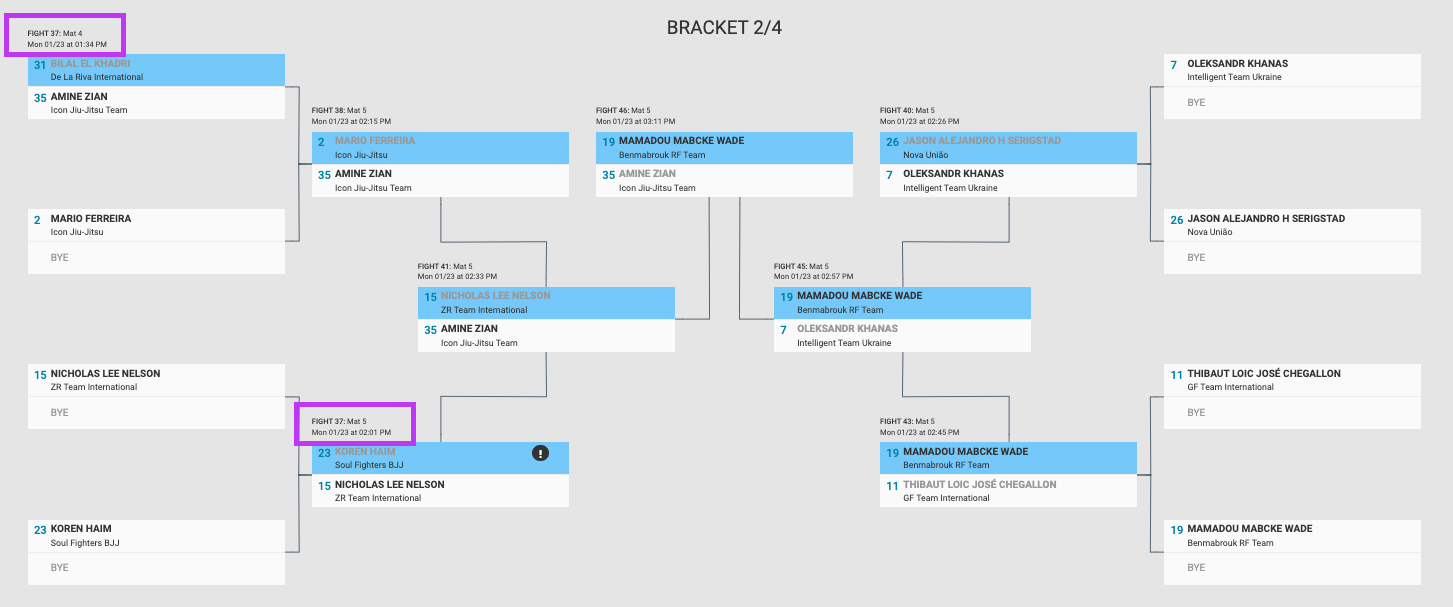

That is why our goal is to map a given results page URL with a unique combination of (fight number, mat, time).

It should also be noted that not all results pages have a brackets, e.g. <a href='https://www.bjjcompsystem.com/tournaments/1985/categories/2139176'>this page</a>.



In [135]:
# 1. Initialise the dataframe that we're going to populate iteratively
df_bracketmap = pd.DataFrame()

# 2. Loop through each "results" page that is linked from the "divisions" page
for i, url in enumerate(df_div['url'][:50]):

    print('{}. Scraping {} ... [{}%]'.format(i + 1, url, round(100 * i / len(df_div), 2)))
    
    # X. Fetch the HTML behind our url
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    body_str = str(soup.find('body'))
    bracket_list = get_brackets(url)

    # X. Define the regex pattern to split our HTML
    cutoff_pattern = ''
    for i in range(len(bracket_list)):
        c = '(' + str(bracket_list[i]) + ')'
        if i == 0:
            cutoff_pattern = c
        else:
            cutoff_pattern = cutoff_pattern + '|' + c      

    # X. Apply the cutoff pattern built above       
    body_str_split = re.split(cutoff_pattern, body_str)        

    # X. Remove the HTML portions we don't care about
    body_str_split = [i for i in body_str_split
                      if i is not None
                      and not i.startswith('<body>')
                      and not i.startswith('<div class="bracket-title">')]

    # X. Build our dataframe
    if len(bracket_list) > 0:
        for i in range(len(body_str_split)):
            df_temp = pd.DataFrame()
            fightno_list = re.findall('(?:<span class="bracket-match-header__fight">)(.+)(?::</span> )(?:.+)(?:</div>\n<div class="bracket-match-header__when">)(?:.+)(?:</div>)'
                                      , body_str_split[i])
            matno_list = re.findall('(?:<span class="bracket-match-header__fight">)(?:.+)(?::</span> )(.+)(?:</div>\n<div class="bracket-match-header__when">)(?:.+)(?:</div>)'
                                      , body_str_split[i])
            datetime_list = re.findall('(?:<span class="bracket-match-header__fight">)(?:.+)(?::</span> )(?:.+)(?:</div>\n<div class="bracket-match-header__when">)(.+)(?:</div>)'
                                      , body_str_split[i])
            df_temp['fightno'] = [f.lower() for f in fightno_list]
            df_temp['matno'] = [f.lower() for f in matno_list]
            df_temp['datetime'] = [f.lower() for f in datetime_list]
            df_temp['url'] = url
            df_temp['bracket'] = extract_bracket_name(bracket_list[i])
            df_bracketmap = pd.concat([df_bracketmap, df_temp], ignore_index = True)
            del df_temp
    else:
        match_list = get_matches(url)
        for i in range(len(match_list)):
            df_temp = pd.DataFrame()
            try:
                df_temp.loc[i, 'fightno'] = extract_fightno(match_list[i])
            except AttributeError:
                df_temp.loc[i, 'fightno'] = np.nan
            try:
                df_temp.loc[i, 'matno'] = extract_matno(match_list[i])
            except AttributeError:
                df_temp.loc[i, 'matno'] = np.nan
            try:
                df_temp.loc[i, 'datetime'] = extract_datetime(match_list[i])
            except AttributeError:
                df_temp.loc[i, 'datetime'] = np.nan
            df_temp['url'] = url
            df_temp['bracket'] = 'Finals'
            df_bracketmap = pd.concat([df_bracketmap, df_temp], ignore_index = True)
            del df_temp
    
print('\n     ... Scraping complete! [100%]')
print('\nDenormalised dataframe generated, here is a sample of records:')
with pd.option_context('display.max_colwidth', None, 'display.max_columns', None, 'display.max_rows', None):
    display(df_bracketmap.sample(30))

1. Scraping https://www.bjjcompsystem.com/tournaments/1985/categories/2138988 ... [0.0%]
2. Scraping https://www.bjjcompsystem.com/tournaments/1985/categories/2138991 ... [0.21%]
3. Scraping https://www.bjjcompsystem.com/tournaments/1985/categories/2138994 ... [0.42%]
4. Scraping https://www.bjjcompsystem.com/tournaments/1985/categories/2138997 ... [0.63%]
5. Scraping https://www.bjjcompsystem.com/tournaments/1985/categories/2139000 ... [0.84%]
6. Scraping https://www.bjjcompsystem.com/tournaments/1985/categories/2139003 ... [1.05%]
7. Scraping https://www.bjjcompsystem.com/tournaments/1985/categories/2139006 ... [1.26%]
8. Scraping https://www.bjjcompsystem.com/tournaments/1985/categories/2139035 ... [1.47%]
9. Scraping https://www.bjjcompsystem.com/tournaments/1985/categories/2139038 ... [1.68%]
10. Scraping https://www.bjjcompsystem.com/tournaments/1985/categories/2139041 ... [1.89%]
11. Scraping https://www.bjjcompsystem.com/tournaments/1985/categories/2139044 ... [2.1%]
12. Scrapi

,fightno,matno,datetime,url,bracket
176,fight 58,mat 1,mon 01/23 at 04:16 pm,https://www.bjjcompsystem.com/tournaments/1985/categories/2139086,Finals
781,fight 9,mat 5,tue 01/24 at 10:28 am,https://www.bjjcompsystem.com/tournaments/1985/categories/2139107,Bracket 6/8
511,fight 27,mat 5,tue 01/24 at 12:34 pm,https://www.bjjcompsystem.com/tournaments/1985/categories/2139092,Bracket 1/4
1226,fight 24,mat 6,wed 01/25 at 12:18 pm,https://www.bjjcompsystem.com/tournaments/1985/categories/2139118,Bracket 1/2
1242,fight 33,mat 7,wed 01/25 at 01:51 pm,https://www.bjjcompsystem.com/tournaments/1985/categories/2139118,Bracket 2/2
1072,fight 5,mat 3,wed 01/25 at 09:55 am,https://www.bjjcompsystem.com/tournaments/1985/categories/2139103,Bracket 4/8
1260,fight 35,mat 2,wed 01/25 at 01:53 pm,https://www.bjjcompsystem.com/tournaments/1985/categories/2139123,Finals
859,fight 26,mat 3,tue 01/24 at 12:40 pm,https://www.bjjcompsystem.com/tournaments/1985/categories/2139112,Bracket 4/4
196,fight 40,mat 5,mon 01/23 at 02:26 pm,https://www.bjjcompsystem.com/tournaments/1985/categories/2139091,Bracket 2/4
782,fight 8,mat 5,tue 01/24 at 10:19 am,https://www.bjjcompsystem.com/tournaments/1985/categories/2139107,Bracket 6/8


### 3.3. <a name='33'>Loop through divisions, brackets and fights to populate denormalised dataframe</a>
(<a href='#0'>Go to top</a>)

In [136]:
col_list = ['url'
            , 'bye'
            , 'fightno'
            , 'matno'
            , 'datetime'
            , 'winnername'
            , 'winnerclub'
            , 'losername'
            , 'loserclub'
            , 'podium_1_rank'
            , 'podium_1_name'
            , 'podium_1_club'
            , 'podium_2_rank'
            , 'podium_2_name'
            , 'podium_2_club'
            , 'podium_3_rank'
            , 'podium_3_name'
            , 'podium_3_club'
            , 'podium_4_rank'
            , 'podium_4_name'
            , 'podium_4_club'
            , 'podium_5_rank'
            , 'podium_5_name'
            , 'podium_5_club'
            , 'podium_6_rank'
            , 'podium_6_name'
            , 'podium_6_club']

df_denorm = pd.DataFrame(columns = col_list)
df_temp = pd.DataFrame(columns = col_list)

# 1. Looping through each "results" page that is linked from the "divisions" page
for i, url in enumerate(df_div['url'][:50]): # enumerate(['https://www.bjjcompsystem.com/tournaments/1985/categories/2139091', 'https://www.bjjcompsystem.com/tournaments/1985/categories/2139176']): # 
    
    print('{}. Scraping {} ... [{}%]'.format(i + 1, url, round(100 * i / len(df_div), 2)))
    
    match_list = get_matches(url)
    df_temp = pd.DataFrame(columns = col_list)
        
    # 2. Iterating through each fight on the results page
    for i in range(len(match_list)):
        try:
            if extract_bye(match_list[i]) == 'BYE':
                df_temp.loc[i, 'bye'] = True
            else:
                df_temp.loc[i, 'bye'] = False
        except AttributeError:
            df_temp.loc[i, 'bye'] = False
        try:
            df_temp.loc[i, 'fightno'] = extract_fightno(match_list[i])
        except AttributeError:
            df_temp.loc[i, 'fightno'] = np.nan
        try:
            df_temp.loc[i, 'matno'] = extract_matno(match_list[i])
        except AttributeError:
            df_temp.loc[i, 'matno'] = np.nan
        try:
            df_temp.loc[i, 'datetime'] = extract_datetime(match_list[i])
        except AttributeError:
            df_temp.loc[i, 'datetime'] = np.nan
        try:
            df_temp.loc[i, 'winnername'] = extract_winnername(match_list[i])
        except AttributeError:
            df_temp.loc[i, 'winnername'] = np.nan
        try:
            df_temp.loc[i, 'winnerclub'] = extract_winnerclub(match_list[i])
        except AttributeError:
            df_temp.loc[i, 'winnerclub'] = np.nan
        try:
            df_temp.loc[i, 'losername'] = extract_losername(match_list[i])
        except AttributeError:
            df_temp.loc[i, 'losername'] = np.nan
        try:
            df_temp.loc[i, 'loserclub'] = extract_loserclub(match_list[i])
        except AttributeError:
            df_temp.loc[i, 'loserclub'] = np.nan
    
    # 3. Add the URL and the podium info (not all results have a podium)
    df_temp['url'] = url
    podium = get_podium(url)
    try:
        podium_rank_list = get_podiumranks(podium)
        podium_name_list = get_podiumnames(podium)
        podium_club_list = get_podiumclubs(podium)
        for i in range(len(podium_rank_list)):
            col_rank = 'podium_{}_rank'.format(i + 1)
            col_name = 'podium_{}_name'.format(i + 1)
            col_club = 'podium_{}_club'.format(i + 1)
            try:
                df_temp[col_rank] = extract_podiumrank(podium_rank_list[i])
            except AttributeError:
                df_temp[col_rank] = np.nan
            try:
                df_temp[col_name] = extract_podiumname(podium_name_list[i])
            except AttributeError:
                df_temp[col_name] = np.nan
            try:
                df_temp[col_club] = extract_podiumclub(podium_club_list[i])
            except AttributeError:
                df_temp[col_club] = np.nan
    except AttributeError:
        for i in range(6):
            col_rank = 'podium_{}_rank'.format(i + 1)
            col_name = 'podium_{}_name'.format(i + 1)
            col_club = 'podium_{}_club'.format(i + 1)
            df_temp[col_rank] = np.nan
            df_temp[col_name] = np.nan
            df_temp[col_club] = np.nan
        
    # 4. Append our temp dataframe to our denorm one and delete the temp one
    df_denorm = pd.concat([df_denorm, df_temp], ignore_index = True)
    del df_temp
        
print('\n     ... Scraping complete! [100%]')

# Enrich our dataframe with the division info
df_denorm = df_denorm.merge(df_div, how = 'inner', on = 'url')

# Enrich our dataframe with the brackets info
df_denorm = df_denorm.merge(df_bracketmap, how = 'left', on = ['url', 'fightno', 'matno', 'datetime'])
df_denorm.sort_values(['url', 'fightno', 'datetime'], ascending = True, inplace = True)

print('\nDenormalised dataframe generated, here are the first records:')
with pd.option_context('display.max_colwidth', None, 'display.max_columns', None, 'display.max_rows', None):
    display(df_denorm.head(30))

1. Scraping https://www.bjjcompsystem.com/tournaments/1985/categories/2138988 ... [0.0%]
2. Scraping https://www.bjjcompsystem.com/tournaments/1985/categories/2138991 ... [0.21%]
3. Scraping https://www.bjjcompsystem.com/tournaments/1985/categories/2138994 ... [0.42%]
4. Scraping https://www.bjjcompsystem.com/tournaments/1985/categories/2138997 ... [0.63%]
5. Scraping https://www.bjjcompsystem.com/tournaments/1985/categories/2139000 ... [0.84%]
6. Scraping https://www.bjjcompsystem.com/tournaments/1985/categories/2139003 ... [1.05%]
7. Scraping https://www.bjjcompsystem.com/tournaments/1985/categories/2139006 ... [1.26%]
8. Scraping https://www.bjjcompsystem.com/tournaments/1985/categories/2139035 ... [1.47%]
9. Scraping https://www.bjjcompsystem.com/tournaments/1985/categories/2139038 ... [1.68%]
10. Scraping https://www.bjjcompsystem.com/tournaments/1985/categories/2139041 ... [1.89%]
11. Scraping https://www.bjjcompsystem.com/tournaments/1985/categories/2139044 ... [2.1%]
12. Scrapi

,url,bye,fightno,matno,datetime,winnername,winnerclub,losername,loserclub,podium_1_rank,podium_1_name,podium_1_club,podium_2_rank,podium_2_name,podium_2_club,podium_3_rank,podium_3_name,podium_3_club,podium_4_rank,podium_4_name,podium_4_club,podium_5_rank,podium_5_name,podium_5_club,podium_6_rank,podium_6_name,podium_6_club,age,belt,weight,gender,bracket
0,https://www.bjjcompsystem.com/tournaments/1985/categories/2138988,True,None,None,None,Chahine Amar Ghoulem,Icon Jiu-Jitsu Team,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,juvenile 1,blue,light feather,male,Finals
1,https://www.bjjcompsystem.com/tournaments/1985/categories/2138991,False,fight 34,mat 5,sat 01/28 at 01:27 pm,Virgile Grandjean-Philibert,WAO,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,juvenile 1,blue,feather,male,Finals
6,https://www.bjjcompsystem.com/tournaments/1985/categories/2138991,False,fight 37,mat 5,sat 01/28 at 01:50 pm,Jose Yeremay Martín Sanchez,Team Gil Catarino,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,juvenile 1,blue,feather,male,Finals
3,https://www.bjjcompsystem.com/tournaments/1985/categories/2138991,False,fight 38,mat 5,sat 01/28 at 01:57 pm,Pohakule'a W. Ho'omana,Nova União,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,juvenile 1,blue,feather,male,Finals
7,https://www.bjjcompsystem.com/tournaments/1985/categories/2138991,False,fight 39,mat 5,sat 01/28 at 02:04 pm,Marouane Saad Diab,The Coachinglab,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,juvenile 1,blue,feather,male,Finals
4,https://www.bjjcompsystem.com/tournaments/1985/categories/2138991,False,fight 42,mat 5,sat 01/28 at 02:25 pm,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,juvenile 1,blue,feather,male,Finals
5,https://www.bjjcompsystem.com/tournaments/1985/categories/2138991,False,fight 43,mat 5,sat 01/28 at 02:32 pm,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,juvenile 1,blue,feather,male,Finals
2,https://www.bjjcompsystem.com/tournaments/1985/categories/2138991,False,fight 46,mat 5,sat 01/28 at 02:53 pm,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,juvenile 1,blue,feather,male,Finals
8,https://www.bjjcompsystem.com/tournaments/1985/categories/2138994,False,fight 31,mat 7,sat 01/28 at 01:03 pm,Ilay Arie Peltz,Soul Fighters BJJ,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,juvenile 1,blue,light,male,Finals
49,https://www.bjjcompsystem.com/tournaments/1985/categories/2138994,False,fight 34,mat 7,sat 01/28 at 01:26 pm,Omar Taiti,CheckMat,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,juvenile 1,blue,light,male,Finals


Next: extract dates and times, heatmap, team perf, % female, fight no is not a unique identifier, is it always the loser that is missing in the case of a BYE?